# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import PIL
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline

In [2]:
from torchvision import transforms
from torchvision.datasets import MNIST

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [6]:
  IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE
LOAD_WEIGHTS = False


Разбейте выборку картинок на train и val:

In [7]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:]

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [8]:
def plot_gallery(images, h, w, n_row=3, n_col=6, channels = 3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        #try:
        plt.imshow(images[i].reshape((h, w, channels)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        #except:
        #    pass

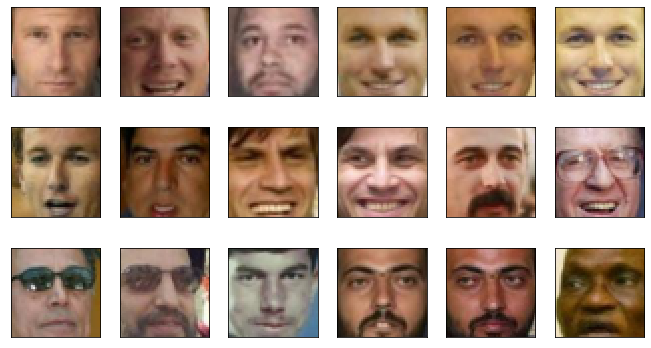

In [9]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [10]:
class Data(torch.utils.data.Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = data
    self.transforms = transforms.Compose([
                                  transforms.ToTensor()
    ])
  def __getitem__(self,index):
    if isinstance(index,slice):
      return torch.stack([self.transforms(self.data[ii]) for ii in range(*index.indices(len(self)))])
    image = self.data[index]
    image = self.transforms(image)
    #image = image.permute(1,2,0)
    return image

  def __len__(self):
    return len(self.data)

In [11]:
Train_dataset = Data(X_train)
Val_dataset = Data(X_val)
train_loader = data_utils.DataLoader(Train_dataset,64)
Val_loader = data_utils.DataLoader(Val_dataset,64)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [12]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [13]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        #<определите архитектуры encoder и decoder>
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3, padding = 1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64,100,3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(100),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(100,64,3,stride=2), nn.Conv2d(64,64,3,padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,32,3,stride=2), nn.Conv2d(32,32,3,padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,3,3,stride=2), nn.Conv2d(3,3,3), nn.ReLU()
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [14]:
criterion = nn.MSELoss()

autoencoder = Autoencoder()
autoencoder.to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [15]:
if LOAD_WEIGHTS:
  autoencoder.load_state_dict(torch.load('autoencoder'))

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [16]:
def show_results(count):
  X = Val_dataset[:count].to(device)
  reconstruction = autoencoder(X)[0].detach().permute(0,2,3,1).cpu()
  X = X.permute(0,2,3,1).cpu()
  images = list(zip(X,reconstruction))
  for i in range(count):
    plot_gallery(images[i],IMAGE_H,IMAGE_W,n_row=1, n_col=2)

In [17]:
def train(model, crit, opt, num_epoches):
  try:
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(num_epoches)):
      for stage in ['train', 'val']:
        if stage == 'train':
          batches_losses = []
          for X in train_loader:
            X = X.to(device)
            opt.zero_grad()
            reconstruction = model(X)[0]
            loss = crit(reconstruction, X)
            loss.backward()
            opt.step()
            batches_losses.append(loss.item())
          train_losses.append(np.mean(batches_losses))

        elif stage == 'val':
          batches_losses = []
          for y in Val_loader:
            y = y.to(device)
            with torch.no_grad():
              reconstruction = model(y)[0]
              loss = crit(reconstruction,y)
              batches_losses.append(loss.item())
          val_losses.append(np.mean(batches_losses))
        else:
          raise KeyError('Wrong stage parameter')
    return train_losses, val_losses
  except KeyboardInterrupt:
    return train_losses, val_losses

**Увеличить batch size/ Взять первую пикчу в отрисовке**




In [18]:
train_losses, val_losses = train(autoencoder,criterion,optimizer,20)

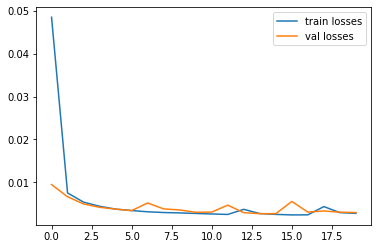

In [19]:
plt.plot(train_losses,label='train losses')
plt.plot(val_losses, label = 'val losses')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


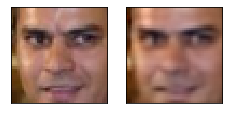

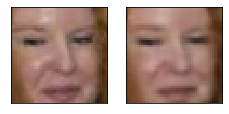

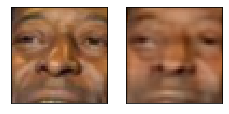

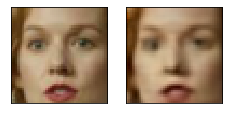

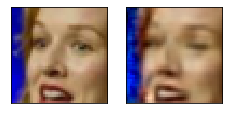

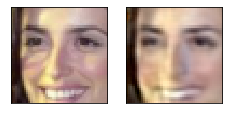

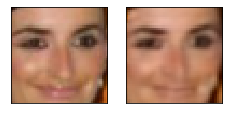

In [120]:
show_results(7)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

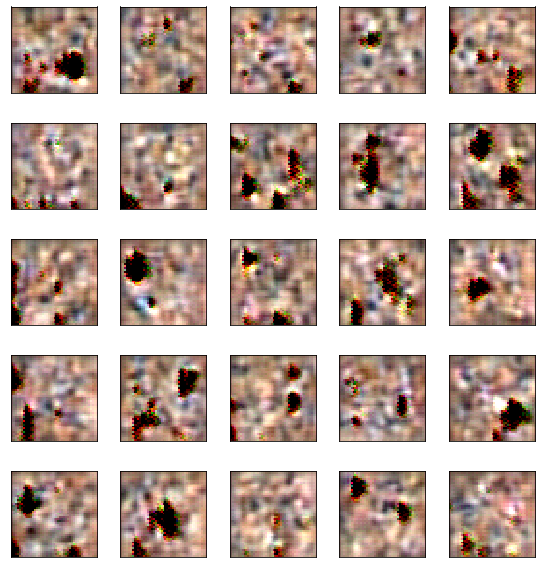

In [21]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.Tensor(np.random.normal(-0.382, 0.9952,size=(25, dim_code,5,5))).to(device)
output = autoencoder.decoder(z)
plot_gallery(output.data.cpu().permute(0,2,3,1).numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5);

# Почему не получилось
Для свёрточного автоенкодера нужно не только угадать распределение но и расположение в 100 слоях по 5x5. Я не смог получить что то дельное таким образом

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [22]:
with_smile = attrs[attrs['Smiling']>2.5].index
without_smile = attrs[attrs['Mouth Closed']>2.2].index

In [23]:
def get_latent_code(model,indexes):
  latent_code = torch.zeros((100,5,5))
  tr = transforms.ToTensor()
  data = [X_train[i] for i in range(len(X_train)) if i in indexes]
  data = [tr(x).to(device) for x in data]
  encoder = model.encoder
  for i in data:
    latent = encoder(i.unsqueeze(0))
    latent_code += latent.squeeze().detach().cpu()
  return latent_code / len(data)

In [24]:
latent_smile = get_latent_code(autoencoder,with_smile)
latent_without_smile = get_latent_code(autoencoder,without_smile)
smile_code = latent_smile-latent_without_smile

In [25]:
def get_photo_changer_function(model, code, alpha = 1):
  encoder = model.encoder
  decoder = model.decoder
  code = code.to(device).unsqueeze(0)
  def f(image):
    image = image.to(device)
    latent = encoder(image)
    latent += code #* alpha
    image = decoder(latent)
    image = image.detach().cpu().squeeze().permute(0,2,3,1)
    return image
  return f

In [26]:
add_smile = get_photo_changer_function(autoencoder,latent_smile)

In [27]:
def show_changed(count, function):
  images = Val_dataset[:count]
  changed_images = function(images)
  items = list(zip(images.permute(0,2,3,1),changed_images))
  for x in items:
    plot_gallery([*x],IMAGE_H,IMAGE_W,n_row=1,n_col=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


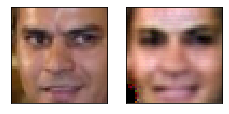

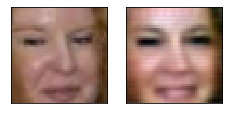

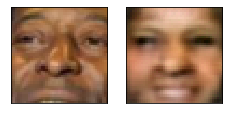

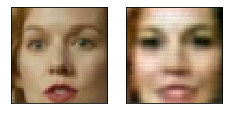

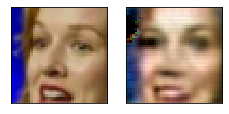

In [28]:
show_changed(5,add_smile)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [29]:
class VEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(45*45*3,3000)
    self.fc2 = nn.Linear(3000,1500)
    self.fc3 = nn.Linear(1500,500)
    self.fc4_1 = nn.Linear(500,100)
    self.fc4_2 = nn.Linear(500,100)

  def forward(self,X):
    X = torch.flatten(X,start_dim=1)
    X = torch.relu(self.fc1(X))
    X = torch.relu(self.fc2(X))
    X = torch.relu(self.fc3(X))
    mu = torch.tanh(self.fc4_1(X))
    logsigma = torch.tanh(self.fc4_2(X))
    return mu, logsigma
    


In [30]:
class VDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(100,500)
    self.fc2 = nn.Linear(500,1500)
    self.fc3 = nn.Linear(1500,3000)
    self.fc4 = nn.Linear(3000,45*45*3)

  def forward(self,X):
    X = torch.relu(self.fc1(X))
    X = torch.relu(self.fc2(X))
    X = torch.relu(self.fc3(X))
    reconstruction = torch.sigmoid(self.fc4(X))
    return reconstruction


In [31]:
class VAE(nn.Module):
    def __init__(self,training = True):
        super().__init__()
        self.encoder = VEncoder()
        self.decoder = VDecoder()
        self.training = training

    def encode(self, x):
        mu, logsigma = self.encoder(x)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add(mu)
        else:
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z)
        return x, mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [42]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    logsigma = logsigma.exp()
    loss = -0.5*torch.sum(1+torch.log(logsigma.pow(2))-mu.pow(2)-logsigma.pow(2))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    x = torch.flatten(x,start_dim=1)
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

In [33]:
def VAEtrain(model, crit, opt, num_epoches):
  try:
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(num_epoches)):
      for stage in ['train', 'val']:
        if stage == 'train':
          model.training = True
          batches_losses = []
          for X in train_loader:
            X = X.to(device)
            opt.zero_grad()
            X, mu, logsigma, reconstruction = model(X)
            loss = crit(X, mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            batches_losses.append(np.mean(loss.item()))
          train_losses.append(np.mean(batches_losses))

        elif stage == 'val':
          model.training = False
          batches_losses = []
          for y in Val_loader:
            y = y.to(device)
            with torch.no_grad():
              y, mu, logsigma, reconstruction = model(y)
              loss = crit(y, mu, logsigma, reconstruction)
              batches_losses.append(np.mean(loss.item()))
          val_losses.append(np.mean(batches_losses))
        else:
          raise KeyError('Wrong stage parameter')
    return train_losses, val_losses
  except KeyboardInterrupt:
    return train_losses, val_losses

In [43]:
criterion = loss_vae

Vautoencoder = VAE().to(device)

optimizer = torch.optim.Adam(Vautoencoder.parameters(),lr=0.0001)

In [35]:
if LOAD_WEIGHTS:
  Vautoencoder.load_state_dict(torch.load('Vautoencoder'))

И обучим модель:

In [36]:
Train_dataset = Data(X_train)
Val_dataset = Data(X_val)
train_loader = data_utils.DataLoader(Train_dataset,64)
Val_loader = data_utils.DataLoader(Val_dataset,64)

In [37]:
train_losses = []
val_losses = []

In [44]:
train_losses, val_losses = VAEtrain(Vautoencoder,criterion,optimizer,40)

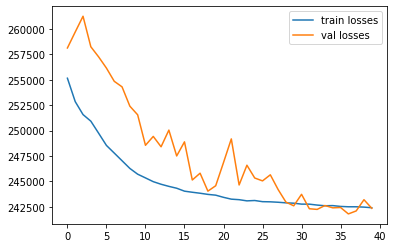

In [45]:
plt.plot(train_losses,label='train losses')
plt.plot(val_losses, label = 'val losses')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [46]:
def show_results_VAE(count):
  X = Val_dataset[:count].to(device)
  autoencoder.training=True
  reconstruction = Vautoencoder(X)[3].detach().cpu().reshape(-1,3,IMAGE_H,IMAGE_W)
  reconstruction = reconstruction.permute(0,2,3,1)
  X = X.permute(0,2,3,1).cpu()
  images = list(zip(X,reconstruction))
  for i in range(count):
    plot_gallery(images[i],IMAGE_H,IMAGE_W,n_row=1, n_col=2)


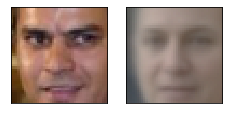

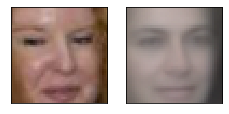

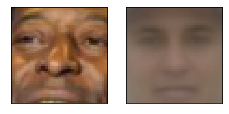

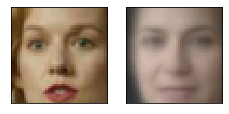

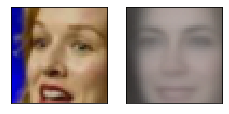

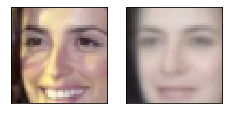

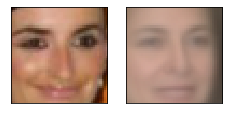

In [47]:
show_results_VAE(7)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

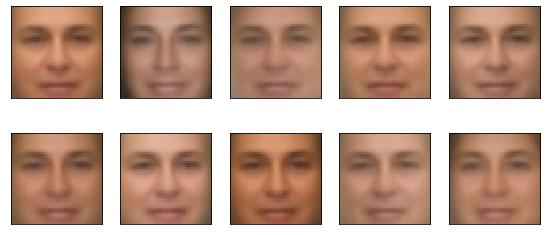

In [49]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.Tensor(np.array([np.random.normal(0, 1, 100) for i in range(10)])).to(device)
output = Vautoencoder.decode(z).detach().cpu().reshape(-1,3,IMAGE_H,IMAGE_W).permute(0,2,3,1)
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [50]:
from sklearn.manifold import TSNE

In [51]:
def latent_Representation(Vautoencoder, data):
  data = torch.Tensor(data).to(device).permute(0,3,1,2)
  mu, logsigma = Vautoencoder.encode(data)
  mu = mu.detach().cpu()
  logsigma = logsigma.detach().cpu()
  mu = Vautoencoder.gaussian_sampler(mu,logsigma)
  X_embedded = TSNE(n_components=2).fit_transform(mu)
  return X_embedded


In [52]:
def get_mask(labels,parameter, border):
  mask = labels[parameter] >= border
  return mask

In [53]:
Emb = latent_Representation(Vautoencoder,X_train)

In [54]:
mask = get_mask(attrs,'Male',0.7)[:10000]
X = Emb[:,0]
Y = Emb[:,1]

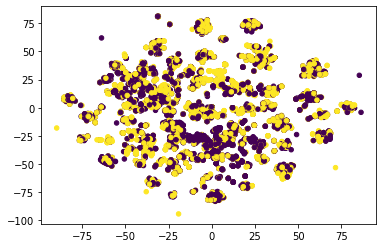

In [61]:
plt.scatter(X,Y,c=mask,s=20)

Что вы думаете о виде латентного представления?

Енкодер работает плохо. Чёткая граница не наблюдается

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
mnist_data_train = MNIST('mnist/',download=True);
mnist_data_val = MNIST('mnist/',train=False ,download=True);

In [63]:
class CVAE_dataset(torch.utils.data.Dataset):
  def __init__(self, data,numClasses):
    super().__init__()
    self.num_classes = numClasses
    self.data = data
    self.transforms = transforms.Compose([
                                          transforms.ToTensor()
    ])
  
  def __getitem__(self,index):
    image, number = self.data[index]
    one_hot = torch.zeros(self.num_classes)
    one_hot[number] = 1
    image = self.transforms(image)
    return image, one_hot
  
  def __len__(self):
    return len(self.data)


In [64]:
Train_dataset = CVAE_dataset(mnist_data_train,10)
Val_dataset = CVAE_dataset(mnist_data_val,10)
train_loader = data_utils.DataLoader(Train_dataset,64,drop_last=True)
Val_loader = data_utils.DataLoader(Val_dataset,64)

In [65]:
class VEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28+10,512)
    self.fc2 = nn.Linear(512,256)
    self.fc3 = nn.Linear(256,128)
    self.fc4_1 = nn.Linear(128,100)
    self.fc4_2 = nn.Linear(128,100)

  def forward(self,X, cls):
    X = torch.flatten(X,start_dim=1)
    X = torch.cat((X, cls),dim=1)
    X = torch.relu(self.fc1(X))
    X = torch.relu(self.fc2(X))
    X = torch.relu(self.fc3(X))
    mu = torch.tanh(self.fc4_1(X))
    logsigma = torch.tanh(self.fc4_2(X))
    return mu, logsigma
    


In [66]:
class VDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(110,128)
    self.fc2 = nn.Linear(128,256)
    self.fc3 = nn.Linear(256,512)
    self.fc4 = nn.Linear(512,28*28)

  def forward(self,X, cls):
    X = torch.cat((X,cls),dim=1)
    X = torch.relu(self.fc1(X))
    X = torch.relu(self.fc2(X))
    X = torch.relu(self.fc3(X))
    reconstruction = torch.sigmoid(self.fc4(X))
    return reconstruction


In [67]:
class CVAE(nn.Module):
    def __init__(self,training = True):
        super().__init__()
        self.encoder = VEncoder()
        self.decoder = VDecoder()
        self.training = training

    def encode(self, x, cls):
        mu, logsigma = self.encoder(x, cls)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add(mu)
        else:
            return mu
    
    def decode(self, z,cls):
        reconstruction = self.decoder(z,cls)
        return reconstruction

    def forward(self, x, cls):
        mu, logsigma = self.encode(x, cls)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z,cls)
        return x, mu, logsigma, reconstruction
  

In [68]:
def CVAEtrain(model, crit, opt, num_epoches):
  try:
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(num_epoches)):
      for stage in ['train', 'val']:
        if stage == 'train':
          model.training = True
          batches_losses = []
          for X, cls in train_loader:
            X = X.to(device)
            cls = cls.to(device)
            opt.zero_grad()
            X, mu, logsigma, reconstruction = model(X, cls)
            loss = crit(X, mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            batches_losses.append(np.mean(loss.item()))
          train_losses.append(np.mean(batches_losses))

        elif stage == 'val':
          model.training = False
          batches_losses = []
          for y, cls in Val_loader:
            y = y.to(device)
            cls = cls.to(device)
            with torch.no_grad():
              y, mu, logsigma, reconstruction = model(y, cls)
              loss = crit(y, mu, logsigma, reconstruction)
              batches_losses.append(np.mean(loss.item()))
          val_losses.append(np.mean(batches_losses))
        else:
          raise KeyError('Wrong stage parameter')
    return train_losses, val_losses
  except KeyboardInterrupt:
    return train_losses, val_losses

In [69]:
criterion = loss_vae

Cautoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(Cautoencoder.parameters(),lr=0.0001)

In [ ]:
if LOAD_WEIGHTS:
  Cautoencoder.load_state_dict(torch.load('Cautoencoder'))

In [70]:
train_losses, val_losses = CVAEtrain(Cautoencoder,criterion,optimizer,40)

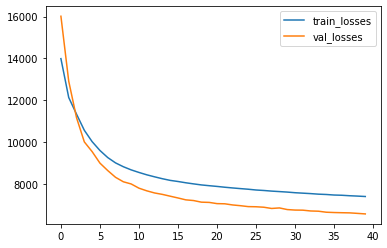

In [71]:
plt.plot(train_losses,label = 'train_losses')
plt.plot(val_losses, label = 'val_losses')
plt.legend()
plt.show()

In [72]:
def C_plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        #try:
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        #except:
        #    pass

In [73]:
def show_results_CVAE(count):

  X, cls = Val_dataset[:count].to(device)
  Cautoencoder.training=True
  reconstruction = Cautoencoder(X,cls)[3].detach().cpu().reshape(-1,1,28,28)
  reconstruction = reconstruction.permute(0,2,3,1)
  X = X.permute(0,2,3,1).cpu()
  images = list(zip(X,reconstruction))
  for i in range(count):
    plot_gallery(images[i],IMAGE_H,IMAGE_W,n_row=1, n_col=2)


## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

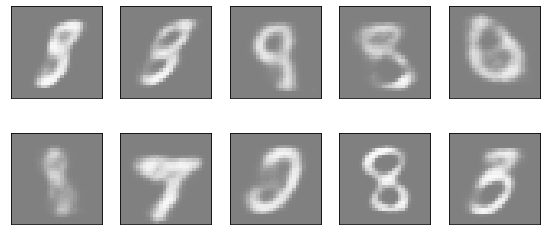

In [77]:
cls = 8

one_hot = torch.zeros((10,10))
one_hot[cls]=1
one_hot = one_hot.to(device)
z = torch.Tensor(np.array([np.random.normal(0, 1, 100) for i in range(10)])).to(device)
output = Cautoencoder.decode(z,one_hot).detach().cpu().reshape(-1,1,28,28).permute(0,2,3,1).squeeze()
C_plot_gallery(output.data.cpu().numpy(), 28, 28, n_row=2, n_col=5)

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [79]:
from sklearn.manifold import TSNE

In [84]:
def C_latent_Representation(Cautoencoder):
  latent_space = []
  numbers = []
  tf = transforms.ToTensor()
  for x, cls in train_loader:
    cls = cls.to(device)
    x = x.to(device)
    mu, logsigma = Cautoencoder.encode(x, cls)
    mu = mu.detach().cpu()
    logsigma = logsigma.detach().cpu()
    mu = Cautoencoder.gaussian_sampler(mu,logsigma)
    mu = torch.reshape(mu,(-1,100))
    mu = torch.cat((mu, cls.cpu()),dim = 1) #13123123
    cls = cls.reshape(-1,10)
    latent_space.append(mu.data)
    numbers.append(cls.data)
  latent_space = torch.stack(latent_space).reshape(-1,110)
  numbers = torch.stack(numbers).reshape(-1,10).squeeze().cpu()
  numbers = [(el == 1).nonzero().squeeze() for el in numbers]
  return latent_space, numbers


In [85]:
latent_space, numbers = C_latent_Representation(Cautoencoder)

In [86]:
sp = np.array(latent_space)

In [ ]:
raise AssertionError

In [ ]:
X_embedded = TSNE(n_components=2,verbose=3).fit_transform(sp) #Осторожно, очень долго

In [88]:
X = X_embedded[:,0]
Y = X_embedded[:,1]

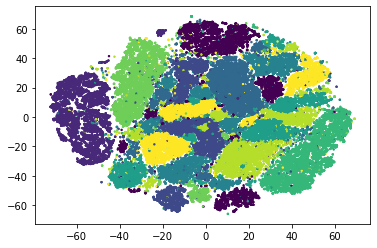

In [89]:
plt.scatter(X,Y,c=numbers,s=2)

Уже видны границы но распределение латентных фекторов по прежнему не идеальное 

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [91]:
Train_dataset = Data(X_train)
Val_dataset = Data(X_val)
train_loader = data_utils.DataLoader(Train_dataset,64)
Val_loader = data_utils.DataLoader(Val_dataset,64)

In [125]:
batch = iter(train_loader).next()
Image_a = batch[0].unsqueeze(0).to(device)
Image_b = batch[5].unsqueeze(0).to(device)
latent_a = autoencoder.encoder(Image_a)
latent_b = autoencoder.encoder(Image_b)
a = [0,0.2,0.4,0.6,0.8,1]
latent = [k*latent_a +(1-k)*latent_b for k in a]
Images = [autoencoder.decoder(lat).detach().cpu().permute(0,2,3,1) for lat in latent]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


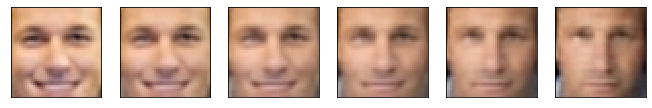

In [126]:
plot_gallery(Images,IMAGE_H,IMAGE_W,n_row=1,n_col=6)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [132]:
class NoisyDataset(data_utils.Dataset):
  def __init__(self, data,noise_factor):
    super().__init__()
    self.data = data
    self.transforms = transforms.Compose([
                                  transforms.ToTensor()
    ])
    self.noise_factor = noise_factor
  def __getitem__(self,index):
    image = self.data[index]
    noisy_image = image + self.noise_factor * np.random.normal(loc=0.0, scale=30.0, size=image.shape)
    image = self.transforms(image).float()
    noisy_image = self.transforms(noisy_image)/255
    noisy_image.requires_grad=False
    noisy_image=noisy_image.float()
    return noisy_image, image

  def __len__(self):
    return len(self.data)

In [133]:
noisy_train = NoisyDataset(X_train,0.5)
noisy_val = NoisyDataset(X_val,0.5)
train_loader = data_utils.DataLoader(noisy_train,batch_size=32)
Val_loader = data_utils.DataLoader(noisy_val,batch_size=32)

In [129]:
criterion = nn.MSELoss()

Dautoencoder = Autoencoder()
Dautoencoder.to(device)

optimizer = torch.optim.Adam(Dautoencoder.parameters())

In [ ]:
if LOAD_WEIGHTS:
  Dautoencoder.load_state_dict(torch.load('Dautoencoder'))

In [130]:
def Dtrain(model, crit, opt, num_epoches):
  try:
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(num_epoches)):
      for stage in ['train', 'val']:
        if stage == 'train':
          batches_losses = []
          for X, z in train_loader:
            X = X.to(device)
            z = z.to(device)
            opt.zero_grad()
            reconstruction = model(X)[0]
            loss = crit(reconstruction, z)
            loss.backward()
            opt.step()
            batches_losses.append(loss.item())
          train_losses.append(np.mean(batches_losses))

        elif stage == 'val':
          batches_losses = []
          for y, z in Val_loader:
            y = y.to(device)
            z = z.to(device)
            with torch.no_grad():
              reconstruction = model(y)[0]
              loss = crit(reconstruction,z)
              batches_losses.append(loss.item())
          val_losses.append(np.mean(batches_losses))
        else:
          raise KeyError('Wrong stage parameter')
    return train_losses, val_losses
  except KeyboardInterrupt:
    return train_losses, val_losses

In [134]:
train_losses, val_losses = Dtrain(Dautoencoder,criterion,optimizer,20)

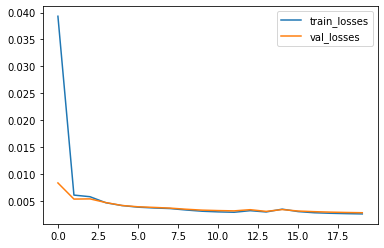

In [135]:
plt.plot(train_losses,label='train_losses')
plt.plot(val_losses,label='val_losses')
plt.legend()
plt.show()

In [136]:
def d_show(model,count):
  for x, z in Val_loader:
    x = x.to(device)
    z = z.to(device)
    reconstruction = model(x)[0]
    r_images = reconstruction.detach().cpu().permute(0,2,3,1)
    x_images = x.detach().cpu().permute(0,2,3,1)
    z_images = z.detach().cpu().permute(0,2,3,1)
    images = list(zip(x_images,r_images))
    break
  for c, i in enumerate(images):
    plot_gallery(i,IMAGE_H,IMAGE_W,n_row=1,n_col=2)
    if c== count:
      break



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


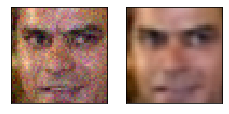

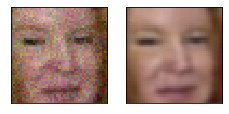

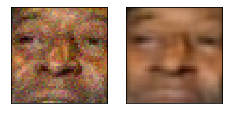

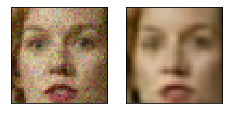

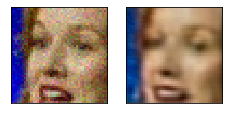

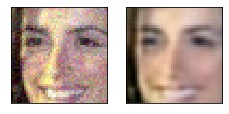

In [137]:
d_show(Dautoencoder,5)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [139]:
class OcclusionDataset(data_utils.Dataset):
  def __init__(self, data,noise_factor):
    super().__init__()
    self.data = data
    self.transforms1 = transforms.Compose([
                                  transforms.ToTensor()
    ])
    self.transforms2 = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.RandomErasing(p=1)
    ])
  def __getitem__(self,index):
    data = self.data[index]
    image = self.transforms1(data)
    oc = self.transforms2(data)
    return oc, image

  def __len__(self):
    return len(self.data)

In [140]:
noisy_train = OcclusionDataset(X_train,0.5)
noisy_val = OcclusionDataset(X_val,0.5)
train_loader = data_utils.DataLoader(noisy_train,batch_size=32)
Val_loader = data_utils.DataLoader(noisy_val,batch_size=32)

In [141]:
def Otrain(model, crit, opt, num_epoches):
  try:
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(num_epoches)):
      for stage in ['train', 'val']:
        if stage == 'train':
          batches_losses = []
          for X, z in train_loader:
            X = X.to(device)
            z = z.to(device)
            opt.zero_grad()
            reconstruction = model(X)[0]
            loss = crit(reconstruction, z)
            loss.backward()
            opt.step()
            batches_losses.append(loss.item())
          train_losses.append(np.mean(batches_losses))

        elif stage == 'val':
          batches_losses = []
          for y, z in Val_loader:
            y = y.to(device)
            z = z.to(device)
            with torch.no_grad():
              reconstruction = model(y)[0]
              loss = crit(reconstruction,z)
              batches_losses.append(loss.item())
          val_losses.append(np.mean(batches_losses))
        else:
          raise KeyError('Wrong stage parameter')
    return train_losses, val_losses
  except KeyboardInterrupt:
    return train_losses, val_losses

In [142]:
criterion = nn.MSELoss()

Oautoencoder = Autoencoder()
Oautoencoder.to(device)

optimizer = torch.optim.Adam(Oautoencoder.parameters())

In [ ]:
if LOAD_WEIGHTS:
  Oautoencoder.load_state_dict(torch.load('Oautoencoder'))

In [143]:
train_losses, val_losses = Otrain(Oautoencoder,criterion,optimizer,20)

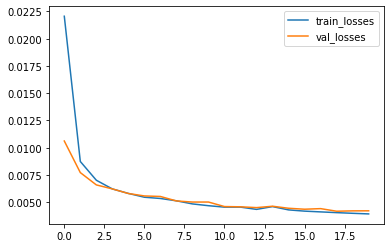

In [144]:
plt.plot(train_losses,label='train_losses')
plt.plot(val_losses,label='val_losses')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


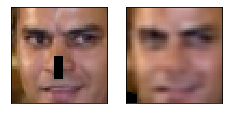

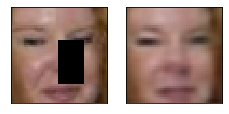

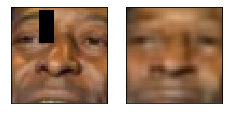

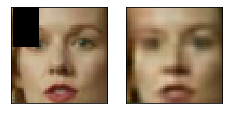

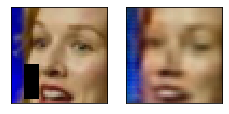

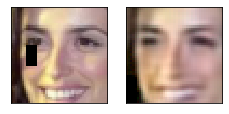

In [145]:
d_show(Oautoencoder,5)

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [147]:
codes = [autoencoder.encoder(torch.Tensor(x).to(device).unsqueeze(0).permute(0,3,1,2)).detach().cpu()for x in X_train]

In [148]:
codes = torch.stack(codes).squeeze()

In [149]:
codes = codes.reshape(-1,2500)

In [151]:
# обучаем LSHForest
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors().fit(codes)

In [152]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у NearestNeighbors ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = autoencoder.encoder(torch.Tensor(image).unsqueeze(0).permute(0,3,1,2).to(device)).detach().cpu().reshape(-1,2500)
    
  (distances,),(idx,) = NN.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [153]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplots_adjust(wspace=1)
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

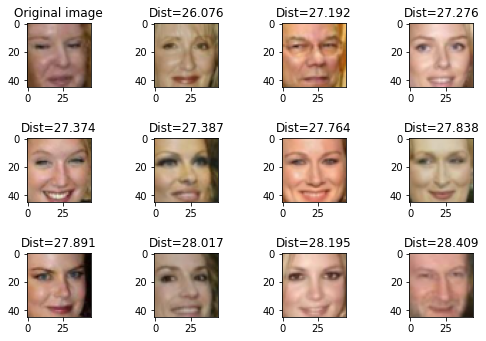

In [154]:
show_similar(X_val[1])

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!